## Тест между группами по метрике линеаризованных лайков

Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns
import hashlib
import pandahouse as ph
import random

In [2]:
# функция для изучения общей информации о датасетах
def general_information(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Дубликатов', data.duplicated().sum(), 'или', round(data.duplicated().sum() / len(data) * 100), '%')

In [3]:
# функция для выполнения запосов
def select(q):
    return ph.read_clickhouse(q, connection=connection)

In [4]:
def ttest(alfa, data_1, data_2, column):
    alpha = alfa # критический уровень статистической значимости
    results = st.ttest_ind(data_1[column], 
           data_2[column], equal_var = False)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [5]:
def test_mannwhitneyu(alfa, data_1, data_2, column):
    alpha = alfa # критический уровень статистической значимости
    results = st.mannwhitneyu(data_1[column], 
           data_2[column], alternative = 'two-sided')
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

### 2. Выгрузка данных по условию

In [6]:
# устанавливаем параметры
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230220'
}

In [7]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 1 и 2 экспериментальные группы
query = '''
select distinct t1.user_id as iser_id, CTR, linearized_likes, exp_group, views, likes from
(select user_id,
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       countIf(user_id, action = 'like') / countIf(user_id, action='view') as CTR,
       countIf(user_id, action = 'like') - (select  countIf(user_id, action = 'like') / countIf(user_id, action='view')
                                            from simulator_20230220.feed_actions 
                                            where  toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (1)) * countIf(user_id, action='view')  as linearized_likes
from simulator_20230220.feed_actions 
group by user_id 
having  toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (1,2)) t2
join 
(select user_id, exp_group from simulator_20230220.feed_actions) t1
using user_id

'''

In [8]:
df_group_1_2 = select(query)

In [9]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 0 и 3 экспериментальные группы
query = '''
select distinct t1.user_id as iser_id, CTR, linearized_likes, exp_group, views, likes from
(select user_id,
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       countIf(user_id, action = 'like') / countIf(user_id, action='view') as CTR,
       countIf(user_id, action = 'like') - (select  countIf(user_id, action = 'like') / countIf(user_id, action='view')
                                            from simulator_20230220.feed_actions 
                                            where  toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (0)) * countIf(user_id, action='view')  as linearized_likes
from simulator_20230220.feed_actions 
group by user_id 
having  toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (0,3)
order by views desc) t2
join 
(select user_id, exp_group from simulator_20230220.feed_actions) t1
using user_id

'''

In [10]:
df_group_0_3 = select(query)

In [11]:
general_information(df_group_0_3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20048 entries, 0 to 20047
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iser_id           20048 non-null  uint32 
 1   CTR               20048 non-null  float64
 2   linearized_likes  20048 non-null  float64
 3   exp_group         20048 non-null  int8   
 4   views             20048 non-null  uint64 
 5   likes             20048 non-null  uint64 
dtypes: float64(2), int8(1), uint32(1), uint64(2)
memory usage: 724.5 KB



,iser_id,CTR,linearized_likes,exp_group,views,likes
0,134465,0.222520,5.327926,3,373,83
1,26400,0.242424,12.410287,0,363,88
2,29014,0.179641,-9.550865,3,334,60
3,130163,0.151057,-18.926157,0,331,50
4,136309,0.165563,-12.887309,0,302,50



Дубликатов 0 или 0 %


### 3. Проверка гипотез t-test и тестом Манна-Уитни

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 После чего сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

#### 3.1. Проанализируем тест между группами 1 и 2 по метрике линеаризованных лайков

##### Нулевая гипотеза(Н0) – средние двух выборок равны (метрика 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠), альтернативная гипотеза(Н1) – метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 2 и 3 экспериментальной группы различаются.

In [12]:
ttest(0.05, df_group_1_2.query('exp_group == 1'), df_group_1_2.query('exp_group == 2'), 'linearized_likes')

p-значение: 9.439432187037712e-10
Отвергаем нулевую гипотезу


##### Нулевая гипотеза(Н0) – нет статистически значимого различия метрики 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 между группами, альтернативная гипотеза(Н1) – разница в метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 между группами статистически значима.¶

In [13]:
test_mannwhitneyu(0.05, df_group_1_2.query('exp_group == 1'), df_group_1_2.query('exp_group == 2'), 'linearized_likes')

p-значение: 9.404319579641738e-27
Отвергаем нулевую гипотезу


t-test - показал противоположный результат после применения линеаризованных лайков. Р-значение было: 6.0376484617779035e-56 после применения теста Манна-Уитни на исходных данных (данные взяты из задания 2), т.е. 𝑝−𝑣𝑎𝑙𝑢𝑒 стало меньше

#### 3.2. Посмотрим на распределения метрики 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 и CTR

Text(0.5, 1.0, 'Распределения получившихся p-values по метрике линеаризованных лайков')

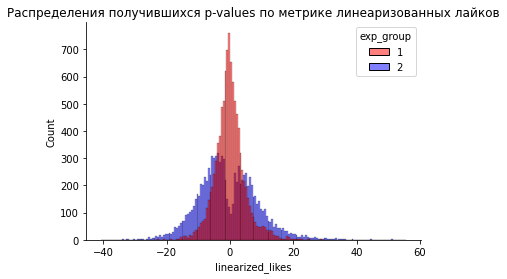

In [14]:
groups = sns.histplot(data = df_group_1_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.despine()
plt.title('Распределения получившихся p-values по метрике линеаризованных лайков')

Text(0.5, 1.0, 'Распределения получившихся p-values до  применения поюзерной метрики')

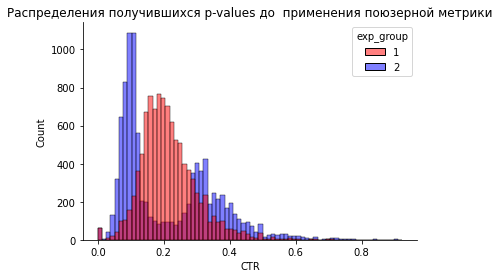

In [15]:
groups = sns.histplot(data = df_group_1_2, 
              x='CTR', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.despine()
plt.title('Распределения получившихся p-values до  применения поюзерной метрики')

У первой группы распеределение стало похоже на нормальное

#### 3.3. Проанализируем тест между группами 0 и 3 по метрике линеаризованных лайков и CTR 

##### Нулевая гипотеза(Н0) – средние двух выборок равны (метрика 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠), альтернативная гипотеза(Н1) – метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 0 и 3 экспериментальной группы различаются.

In [16]:
ttest(0.05, df_group_0_3.query('exp_group == 0'), df_group_0_3.query('exp_group == 3'), 'linearized_likes')

p-значение: 5.491424947968532e-52
Отвергаем нулевую гипотезу


##### Нулевая гипотеза(Н0) – нет статистически значимого различия метрики 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 между группами, альтернативная гипотеза(Н1) – разница в метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 между группами статистически значима.

In [17]:
test_mannwhitneyu(0.05, df_group_0_3.query('exp_group == 0'), df_group_0_3.query('exp_group == 3'), 'linearized_likes')

p-значение: 1.1517315029786597e-63
Отвергаем нулевую гипотезу


В обоих случаях не принимаем нулевую гипотезу

#### 3.4. Проанализируем тесты между группами 0 и 3 по метрике CTR на исходных данных

In [18]:
ttest(0.05, df_group_0_3.query('exp_group == 0'), df_group_0_3.query('exp_group == 3'), 'CTR')

p-значение: 1.0558494146631928e-43
Отвергаем нулевую гипотезу


In [19]:
test_mannwhitneyu(0.05, df_group_0_3.query('exp_group == 0'), df_group_0_3.query('exp_group == 3'), 'CTR')

p-значение: 1.1952055473582936e-57
Отвергаем нулевую гипотезу


Во всех случаях будем считать, что метрики у двух групп отличаются, p-значение после применения новой метрики 𝑝−𝑣𝑎𝑙𝑢𝑒 стало меньше

#### 3.5. Посмотрим на распределения метрики 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 и CTR

Text(0.5, 1.0, 'Распределения получившихся p-values по метрике линеаризованных лайков')

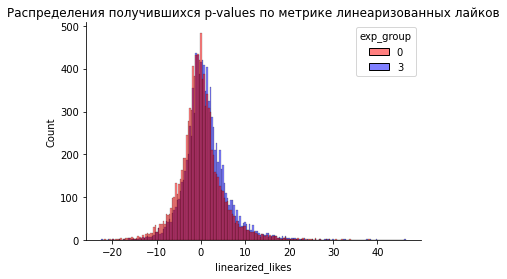

In [20]:
groups = sns.histplot(data = df_group_0_3, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.despine()
plt.title('Распределения получившихся p-values по метрике линеаризованных лайков')

Text(0.5, 1.0, 'Распределения получившихся p-values')

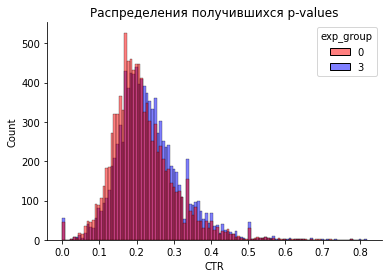

In [21]:
groups = sns.histplot(data = df_group_0_3, 
              x='CTR', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.despine()
plt.title('Распределения получившихся p-values')

Распределения  стали ближе к нормальным

#### Вывод
 Проведение тестов на метрике линеаризованных лайков показало, что отличие в группах есть. P−𝑣𝑎𝑙𝑢𝑒 стали меньше, если сравнивать с тестами проведенными на исходных данных (CTR)